### Performance Analysis

We want to get some exalinability and try to understand what the network learns during in training process.

Unfortunately, using SHAP DeepExplainer isn't available for our model uses EfficientNetv2 which contains unsupported layers such as `StochasticDepth` and
`SiLU`.

While looking for another solution we came across CAM (Class Activation Map), and decided to utilize its main idea to visualize a heatmap of the "network's understanding".

First thing, we load our final model, and delete the classifier layer, leaving only the features extraction part of the network.

In [ ]:
model = ArcNet()

model.load_state_dict(torch.load('/content/drive/MyDrive/Bsc/OpenU/DataScienceWorkshop/model/effnetv2_final_model.pth'))
feature_mapper = model.model.features

feature_mapper.eval()

We define some basic preprocessing

In [ ]:
from google.colab.patches import cv2_imshow

preprocess = transforms.Compose([
   transforms.Resize((384,384)),
   transforms.ToTensor(),
])

def normalize_array(arr):
    arr = 255.0 * (arr - arr.min()) / (arr.max() - arr.min())
    return arr


The activation map takes the output of the last convolutional layer (since we chopped the classifier), which in our network is of size (1280, 12, 12), and locates the max values in each channel, since they are the ones the would later go into the classifier layer and decide which class has the highest score.

we also display areas where values change the most between feature maps.

Pink - high values appear often

Green - high standard deviation between feature maps

White - both above

In [ ]:
def create_activation_map(model, image):
    preds = model(image)
    preds = preds.permute((0,2,3,1))

    img_orig = image.squeeze(0).permute(1,2,0)*255
    heatmap = preds[0]

    heatmap = heatmap.detach().numpy()
    ch0 = np.zeros_like(heatmap[:, :, 0])
    ch1 = np.zeros_like(heatmap[:, :, 0])
    ch2 = np.zeros_like(heatmap[:, :, 0])
    
    # find how often maximum is in each pixel
    for k in range(heatmap.shape[2]):
        p = heatmap[:, :, k]
        mx = p.max()
        if mx == 0:
            continue
        for i in range(heatmap.shape[0]):
            for j in range(heatmap.shape[1]):
                if p[i, j] == mx:
                    ch0[i, j] += 1
                    ch2[i, j] += 1

    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            mn = heatmap[i, j].min()
            mx = heatmap[i, j].max()
            mean = heatmap[i, j].mean()
            std = heatmap[i, j].std()
            ch1[i, j] = std

    # create RGB channels 
    ch0 = normalize_array(ch0)
    ch1 = normalize_array(ch1)*0.6
    ch2 = normalize_array(ch2)
    ch = np.stack((ch0, ch1, ch2), axis=2)

    ch = cv2.resize(ch.astype(np.uint8), (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_LANCZOS4)
    ch = normalize_array(ch)

    # create heatmap of the channels on top of the image
    heat = (0.2 * img_orig + (0.1 * img_orig * ch) / 255 + 0.7 * ch)
    heat = normalize_array(heat)

    img_line = np.concatenate(
        (img_orig, ch, heat), axis=1
    )
    return np.array(img_line)

Finally, we run the activation map on a set of images.

We ran it on various images, and handpicked some interesting examples, though its possible to run it on any chosen sample.

0a58126db.jpg


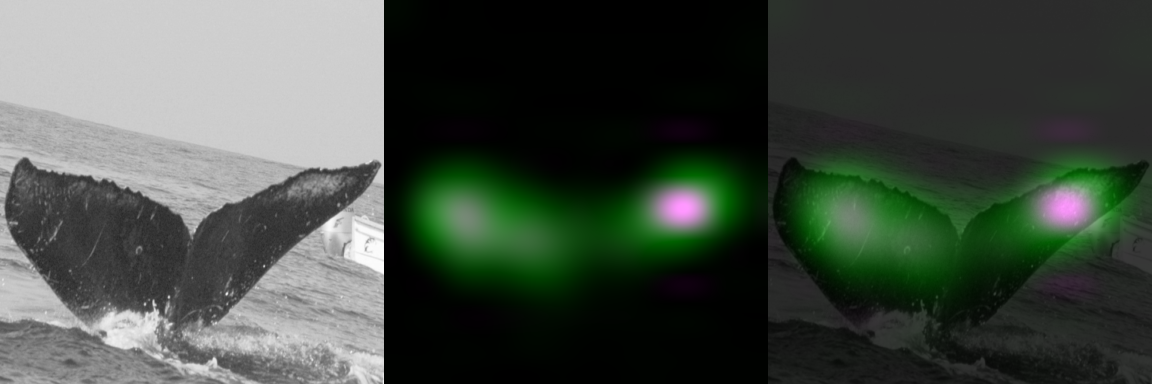

664e007c5.jpg


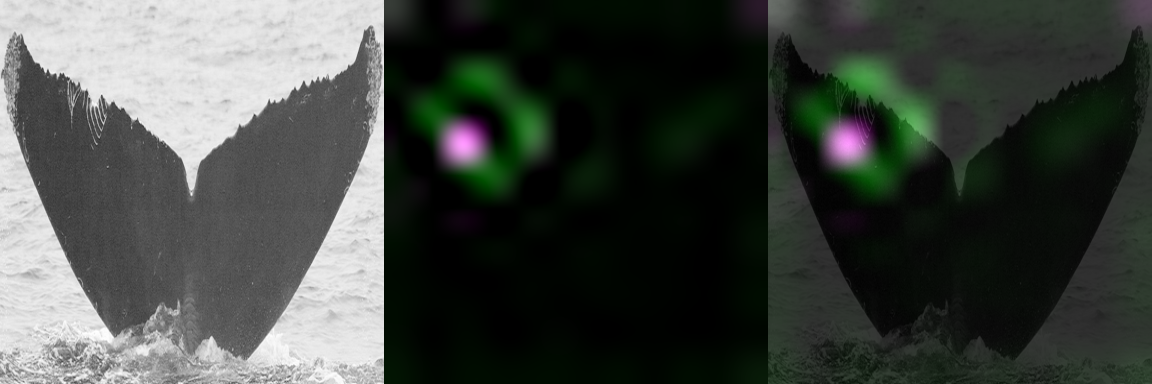

7c7081757.jpg


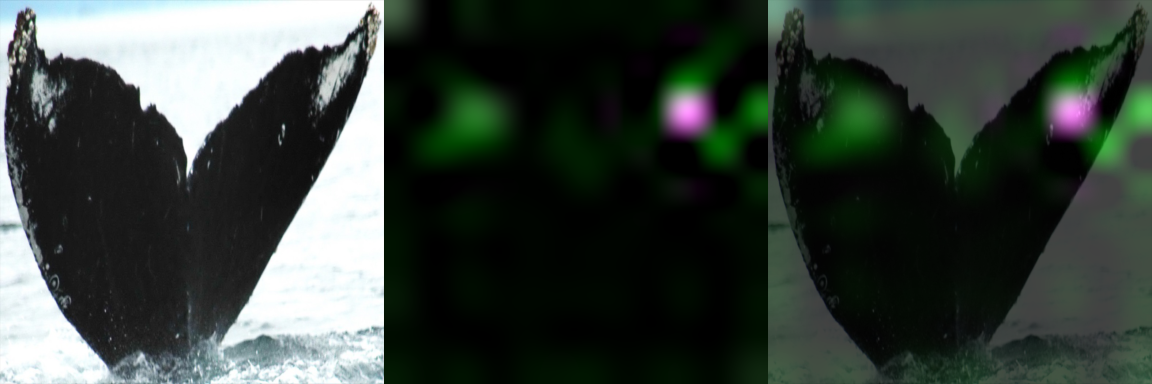

c4f7ac5ff.jpg


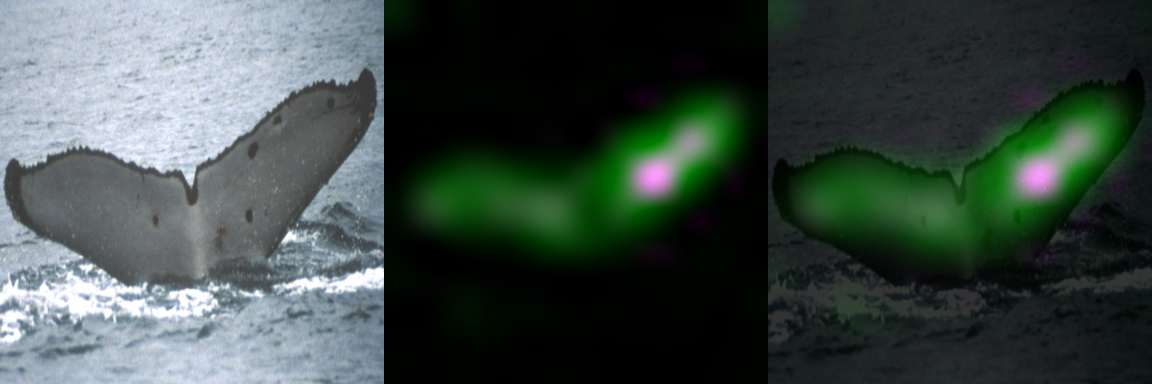

ac595caba.jpg


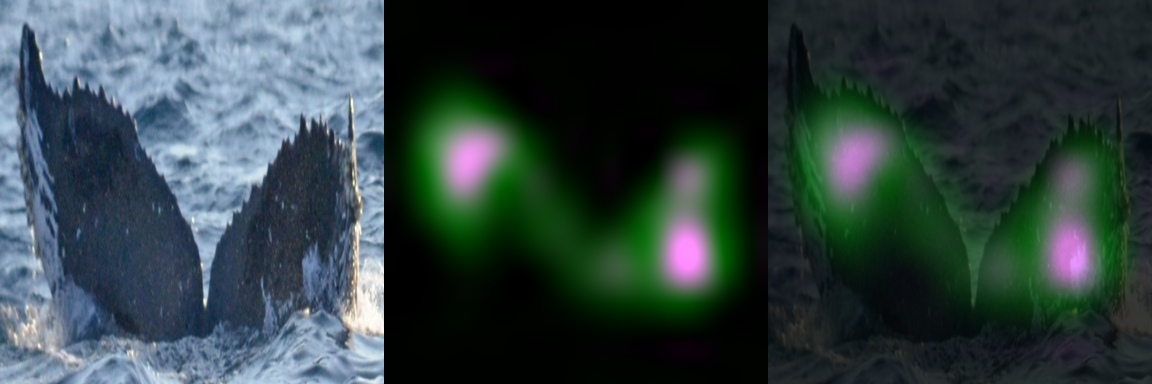

176221f60.jpg


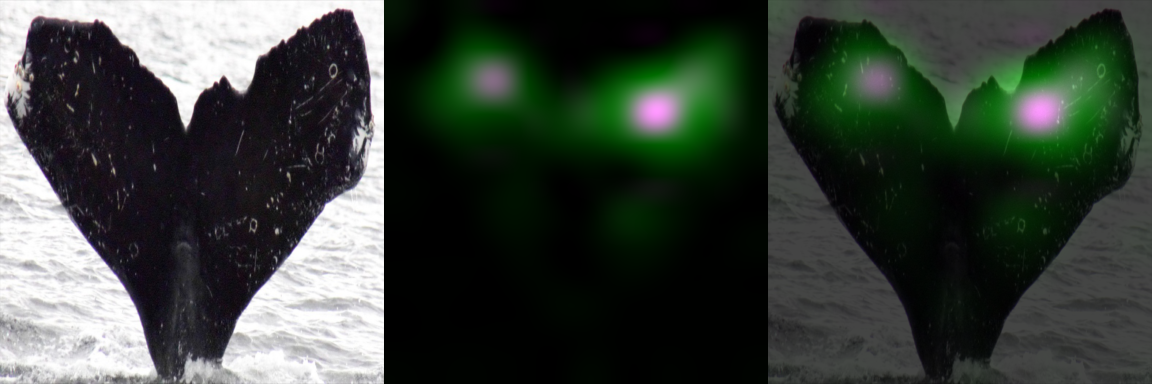

ffe7560cd.jpg


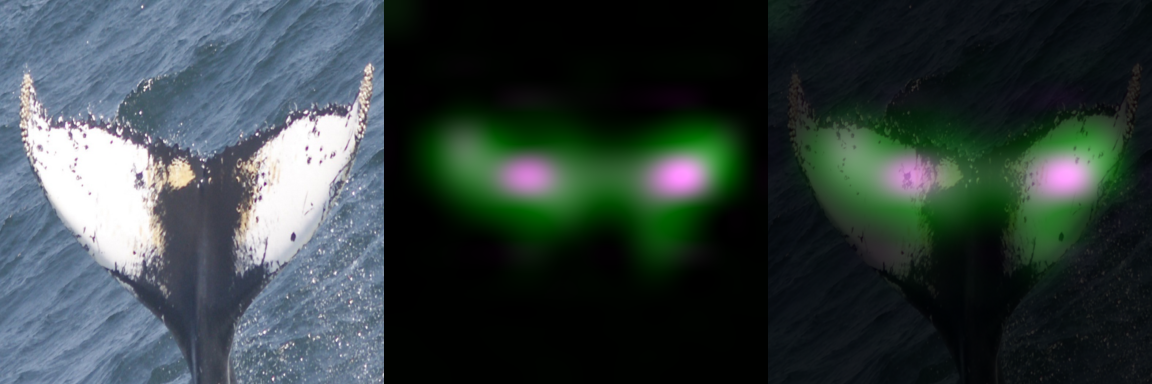

c581881c2.jpg


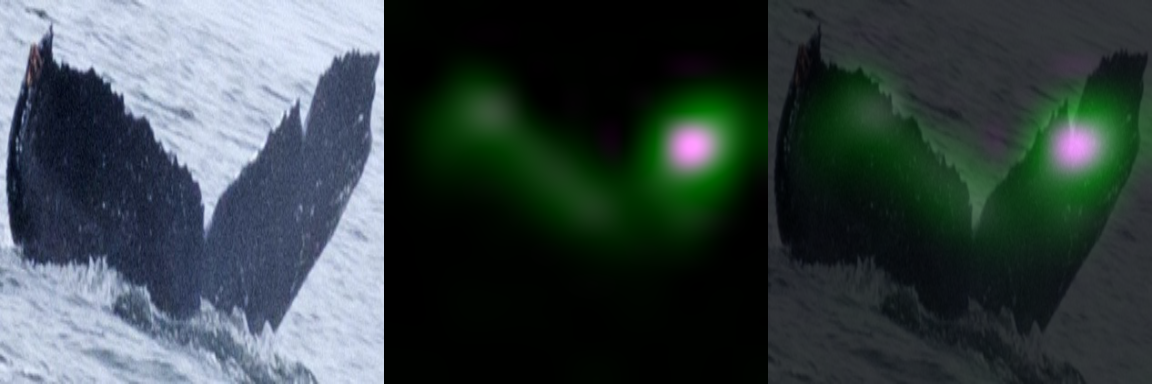

2a744ee56.jpg


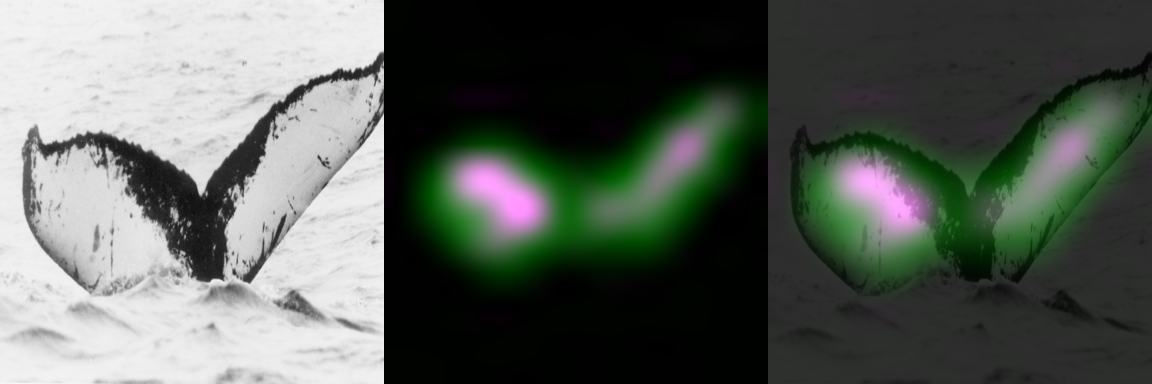

944591a12.jpg


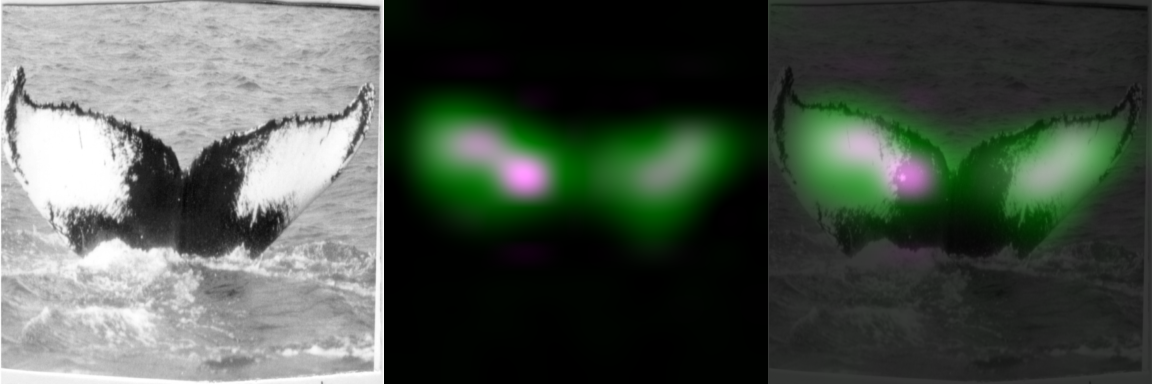

7439a0764.jpg


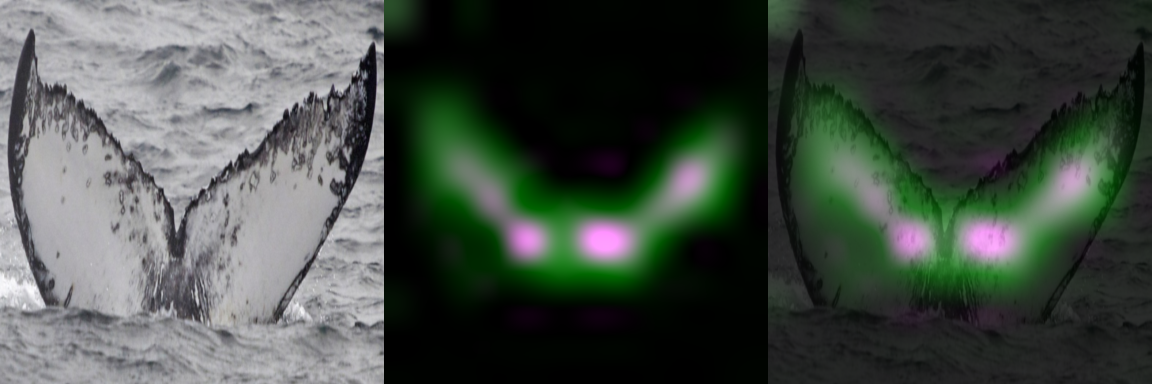

edcd3be38.jpg


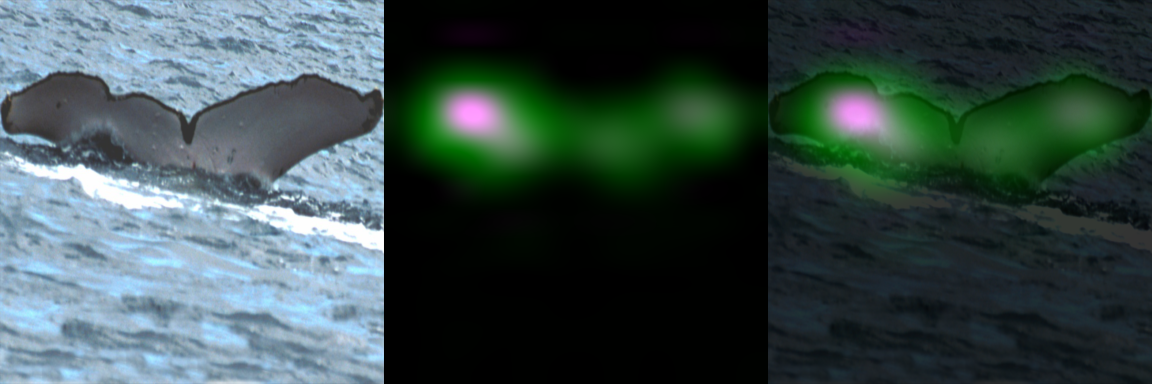

In [ ]:
def create_activation_maps():
    start = 10
    end = 50
    images_names = glob.glob(f"{TRAIN_IMGS_PATH}/*.jpg")[start:end]
    # after some research, these are some of the more interesting examples
    images_names = ['0a58126db.jpg', '664e007c5.jpg', '7c7081757.jpg', 'c4f7ac5ff.jpg',
                    'ac595caba.jpg', '176221f60.jpg', 'ffe7560cd.jpg', 'c581881c2.jpg', 
                    '2a744ee56.jpg', '944591a12.jpg', '7439a0764.jpg', 'edcd3be38.jpg']
    for file_name in images_names:
      image = Image.open(f"{TRAIN_IMGS_PATH}/{file_name}").convert("RGB")
      image = preprocess(image).unsqueeze(0)

      img_line = create_activation_map(feature_mapper, image)
      img = cv2.cvtColor(img_line.astype(np.uint8), cv2.COLOR_RGB2BGR)
      
      print(file_name)
      cv2_imshow(img)


create_activation_maps()

First thing we can say with confidence is that our network actually focuses on flukes and almost ignoring completely the background, which although seems obvious - it's nice to get a validation for it.

Main things we understand from these heatmaps are:
1. special marks on the fluke such as circles, lines, color changes, etc., are very important, and probably are the main factor for the network's decision
2. irregular fluke shape is also a key factor - any spikes, slashs, cuts and in general unique additions to the fluke edges
3. it seem like usually the decision could be made mostly based on one side of the fluke (the one with any of the above - more unique)